#### Importando as bibliotecas e frameworks

In [219]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#### Criando o dataframe inicial

In [220]:
#carregando o dataframe total
df_inicial = pd.read_csv("healthcare-dataset-stroke-data.csv")
#criando o filtro dos individuos com stroke
filtro = df_inicial['stroke'] == 1
#criando os dfs de atingidos e não atingidos por avcs (sem levar em consideração as linhas com Nan's)
df_avc = df_inicial[filtro].dropna()
df_not_avc = df_inicial[~filtro].dropna()
#encontrando a quantidade de individuos com avc
tamanho_maximo = len(df_avc)
#criando o dataframe inicial com proporções iguais de acometidos e não acometidos pelo avc 
df_not_avc = df_not_avc[:tamanho_maximo]
df = pd.concat([df_avc,df_not_avc])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


#### Hipótese nula

In [221]:
#Levando em consideração o df que será utilizado nos experimentos que é composto por metade de pessoas que tiveram avc e metade de pessoas que não tiveram, 
#podemos escolher qualquer um dos casos para servir como a hipotese nula (utilizei os doentes como base).

quantidade_de_atingidos_por_avc_teorico = len(df)
filtro_atingidos = df['stroke'] == 1
df_atingidos_avc = df[filtro_atingidos]
quantidade_de_atingidos_por_avc_real = len(df_atingidos_avc)
acertividade = f"{(quantidade_de_atingidos_por_avc_real/quantidade_de_atingidos_por_avc_teorico)*100} %"
print(acertividade)


50.0 %


#### Separando a coluna de "stroke"

In [222]:
df_strokes = df.pop("stroke")
df_strokes.head()
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked


#### Formatamos o df para ser utilizado na função de treino do sklearn

In [223]:
#get_dummies quando aplicado em uma coluna de dados binários retorna duas colunas no resultado com os nomes das colunas baseados nos valores únicos presentes na coluna original.
df = pd.get_dummies(df).astype(float)
df_strokes =  df_strokes.replace(0, -1)
df = df.drop("id", axis = 1)
#achando o maior valor que será utilizado para deixar as colunas no range de 0 a 1
max_age = df['age'].max()
df['age'] = df['age']/max_age
max_glucose = df['avg_glucose_level'].max()
df['avg_glucose_level'] = df['avg_glucose_level']/max_glucose
max_bmi = df['bmi'].max()
df['bmi'] = df['bmi']/max_bmi
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.817073,0.0,1.0,0.841577,0.564815,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.975610,0.0,1.0,0.389784,0.501543,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.597561,0.0,0.0,0.630124,0.530864,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.963415,1.0,0.0,0.640760,0.370370,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.987805,0.0,0.0,0.685251,0.447531,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [224]:
X_train, X_test, y_train, y_test = train_test_split(df, df_strokes, train_size=0.5)


Acurácia: 0.7033492822966507
[0.48849115 0.03105832 0.         0.13207797 0.12379233 0.
 0.01081589 0.         0.01325841 0.03718393 0.         0.01787508
 0.         0.         0.0191416  0.02467903 0.01981974 0.03785295
 0.02167463 0.02227895]


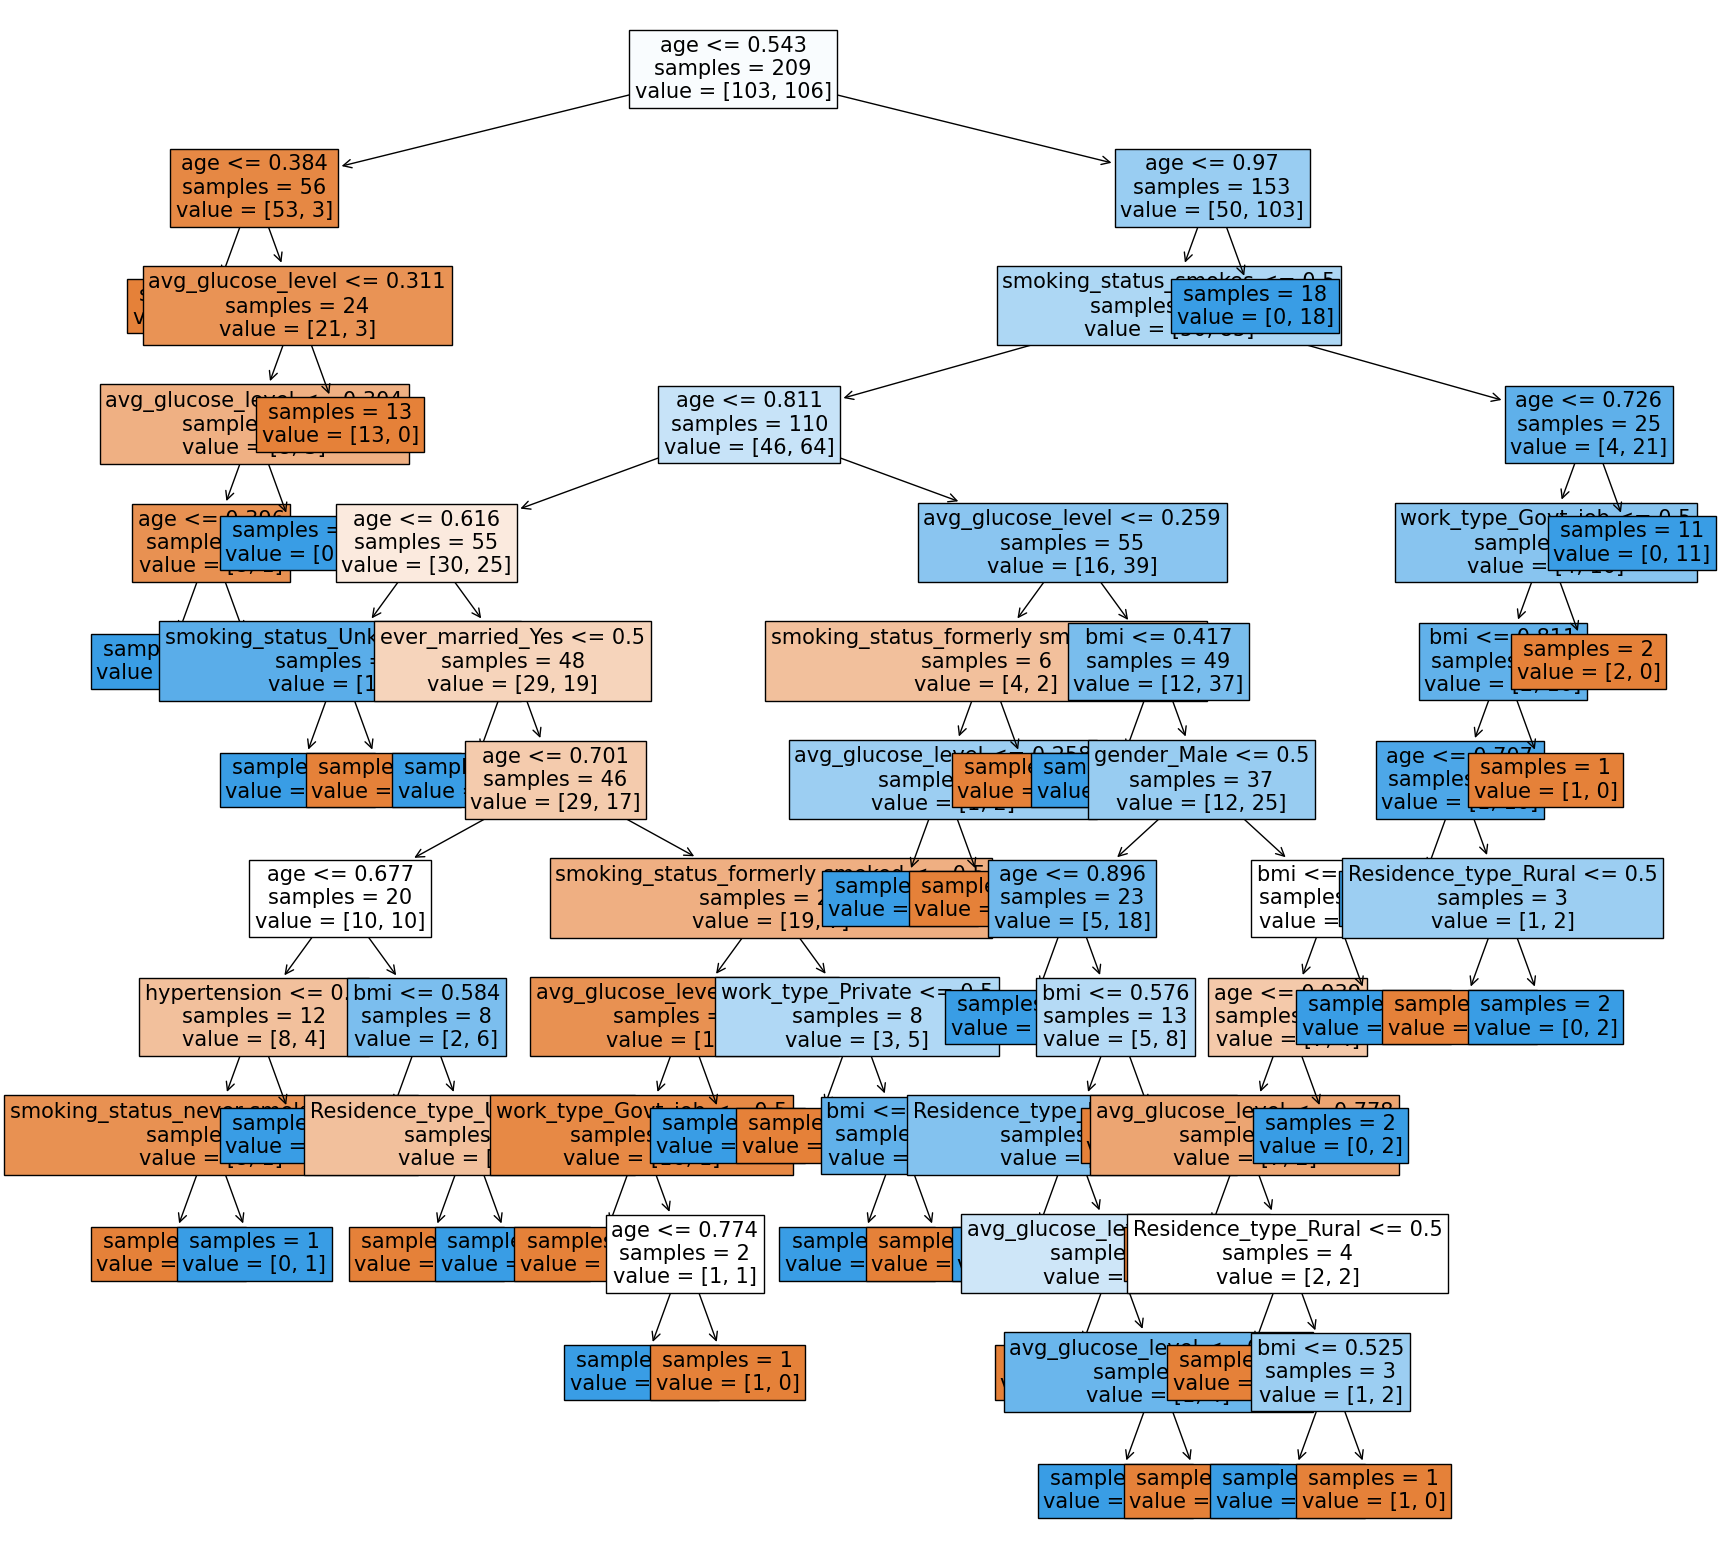

In [225]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)

# Faça previsões nos dados de teste usando a árvore treinada
y_pred = tree.predict(X_test)

# Calcule a acurácia das previsões
acc = accuracy_score(y_test, y_pred)
print("Acurácia:", acc)
print(tree.feature_importances_)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=df.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

In [226]:
X_train.shape
y_train.shape

(209,)

In [227]:
X_train = X_train.to_numpy().T
y_train = y_train.to_numpy()


X_train  = X_train.astype(float)
y_train  = y_train.astype(float)


X_test = X_test.to_numpy().T
y_test = y_test.to_numpy()


X_test  = X_test.astype(float)
y_test  = y_test.astype(float)

print(y_test.shape)

(209,)


In [228]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))


import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad

def loss( parametros ):
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)
    return mse

g = grad(loss)

pontos = X_train
alvos = y_train

w = np.random.randn( 20, 1)
b = np.random.randn()
alpha = 10**-4

for n in range(200000):

    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

print(w)
print(b)
print(len(grad_))

[[ 1.97381845]
 [ 0.15913864]
 [ 0.23688669]
 [ 0.47191732]
 [-0.87888578]
 [ 0.22628044]
 [ 0.12260271]
 [-0.71523047]
 [-0.74929806]
 [ 0.23213782]
 [-1.3980511 ]
 [ 0.65110368]
 [ 0.5923695 ]
 [ 0.98448067]
 [ 0.10006576]
 [ 0.09357855]
 [ 0.03644204]
 [ 0.1068268 ]
 [ 0.19354193]
 [ 0.476981  ]]
-1.52506401046747
4


In [229]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

In [230]:
y_est = w.T @ X_test + b
print(f"{accuracy(y_test, y_est)*100} %")

73.20574162679426 %
